# Exploration des techniques de clustering

Le but de ce tp est de faire face à la problématique: 
<center style="color:red" >  Voici XXX documents -bruts, non étiquetés-... Comment les valoriser? Les exploiter? Les comprendre? Les résumer? </center>

Nous avons vu dans les séances précédentes comment représenter les données textuelles sous forme de sacs de mots:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,D} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,D} \\
	\end{pmatrix}
	\end{matrix}
	$$

A partir de cette représentation, les questions qui se posent sont les suivantes:
1. Quel algorithme de clustiering choisir?
    - K-means, LSA, pLSA, LDA
1. Quels résultats attendre?
    - qualité, bruit, exploitabilité immédiate etc...
1. Quelles analyses qualitatives effectuer pour comprendre les groupes?
1. Comment boucler, itérer pour améliorer la qualité du processus?



In [2]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn
from nltk.corpus import stopwords 
from wordcloud import WordCloud

## Chargement des données



In [24]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train') 


In [4]:
newsgroups_train.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [34]:
import string


punc = string.punctuation
punc += '\n\r\t'
newsgroups_train.data = [doc.translate(str.maketrans(punc, ' ' * len(punc))) for doc in newsgroups_train.data ] 
newsgroups_train.data = [re.sub('[0-9]+', '', doc) for doc in newsgroups_train.data ] # supp nombres

stop_words = (set(stopwords.words('english')))
newsgroups_train_clean =[]
for sentences in newsgroups_train.data :
    newsgroups_train_clean.append(' '.join([word for word in sentences.lower().split() if ((word not in stop_words) and (len(word)>2))]))

print(newsgroups_train_clean[0])

lerxst wam umd edu thing subject car nntp posting host rac wam umd edu organization university maryland college park lines wondering anyone could enlighten car saw day door sports car looked late early called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please mail thanks brought neighborhood lerxst


In [35]:
# conversion BoW + tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer() # TfidfVectorizer(max_features=500)
#vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors = vectorizer.fit_transform(newsgroups_train_clean)
print(vectors.shape)
print(vectors.nnz)
# mesure de la sparsité = 157 mots actif par document sur 130000 !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 93980)
1243401
109.8993282658653


In [36]:
vectors.nnz

1243401

In [37]:
float(vectors.shape[1])

93980.0

In [38]:
# retrouver les mots
print([(i,vectorizer.get_feature_names()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(57135, 'offends'), (49653, 'megatonnes'), (70322, 'rqg'), (89174, 'windogs'), (2308, 'alocohol'), (8880, 'bplpgtlngl'), (15996, 'counterproductive'), (42111, 'karama'), (60809, 'phenomenon'), (48561, 'marx')]


In [39]:
# gestion des étiquettes (pour l'évaluation seulemnet en non-supervisé)
Y = newsgroups_train.target
print(Y[:10]) # numérique
print([newsgroups_train.target_names[i] for i in Y[:10]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware']


# Tests préliminaires

Commençons par le commencement: tout problème non-supervisé (ou presque) doit être analysé en premier lieu avec les $k$-means!


In [9]:
from sklearn.cluster import KMeans
# Algo => risque de prendre du temps si le vocabulaire n'a pas été réduit !!
# Note: on dirait que l'algo transforme les données en dense vector=> catastrophe pour nous !!!
# => limitation du nombre d'itération arbitraire + limitation du vocabulaire

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10)
kmeans.fit(vectors)

KMeans(max_iter=10, n_clusters=20, random_state=0)

In [10]:
# analyse

# recupération des proto:
#print(kmeans.cluster_centers_)

# mots les plus importants par cluster => TODO
# version print / version word cloud

#print(kmeans.labels_)
label = {k:[] for k in range (20)}
for k in range (len(kmeans.labels_)):
    label[kmeans.labels_[k]].append(k)
    
text_cluster = {k:"" for k in range (20)}
for k in range (20):
    text_cluster[k] = ' '.join([newsgroups_train_clean[i] for i in label[k]])

**Mots les plus fréquents**

In [11]:
from collections import Counter
mots_freq = {}

for k,text in text_cluster.items():
    mots_freq[k]=Counter(text.split()).most_common(10)
    
mots_freq

{0: [('columbia', 301),
  ('edu', 301),
  ('gld', 164),
  ('cunixb', 153),
  ('gary', 108),
  ('dare', 106),
  ('insurance', 90),
  ('lines', 81),
  ('subject', 78),
  ('organization', 77)],
 1: [('edu', 456),
  ('msg', 313),
  ('subject', 246),
  ('one', 209),
  ('com', 205),
  ('organization', 198),
  ('lines', 179),
  ('article', 179),
  ('food', 174),
  ('would', 172)],
 2: [('nasa', 1028),
  ('space', 945),
  ('gov', 638),
  ('edu', 588),
  ('subject', 343),
  ('lines', 339),
  ('organization', 333),
  ('article', 278),
  ('ohio', 269),
  ('state', 268)],
 3: [('edu', 1029),
  ('cwru', 349),
  ('subject', 302),
  ('cleveland', 296),
  ('lines', 293),
  ('organization', 290),
  ('andrew', 279),
  ('host', 274),
  ('posting', 262),
  ('nntp', 256)],
 4: [('israel', 846),
  ('israeli', 600),
  ('edu', 502),
  ('jews', 388),
  ('would', 334),
  ('writes', 306),
  ('subject', 293),
  ('arab', 290),
  ('article', 271),
  ('people', 263)],
 5: [('god', 2611),
  ('one', 1652),
  ('people'

**WordCloud**

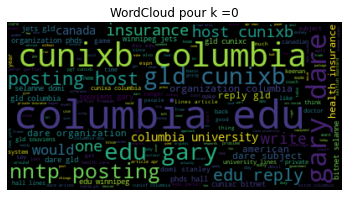

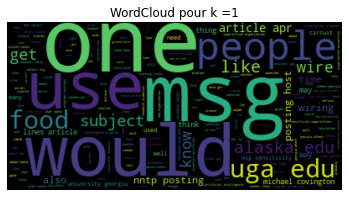

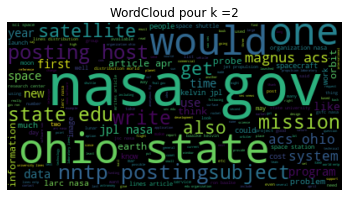

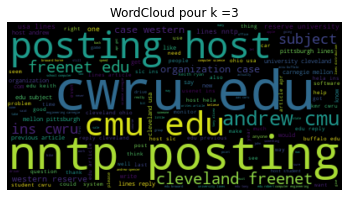

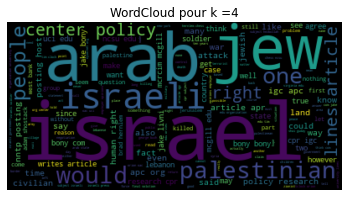

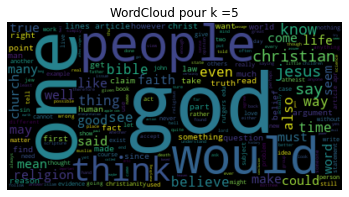

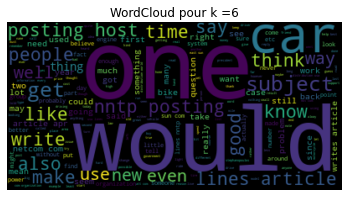

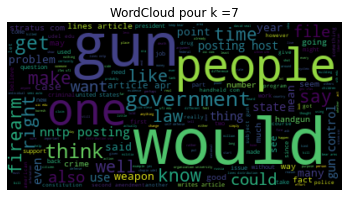

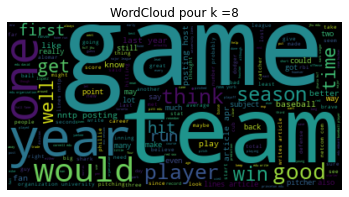

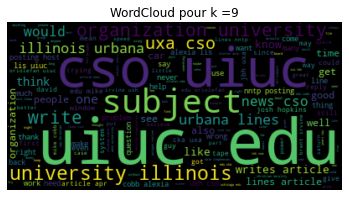

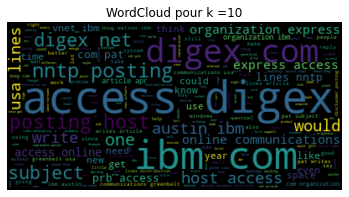

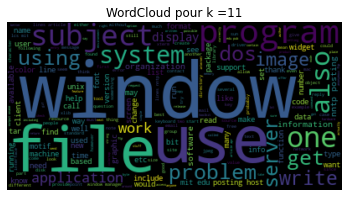

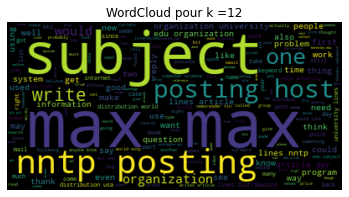

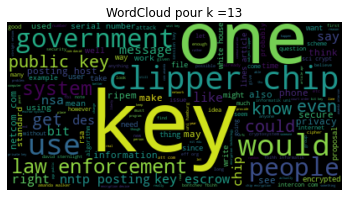

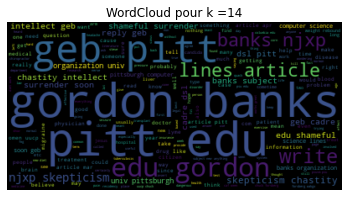

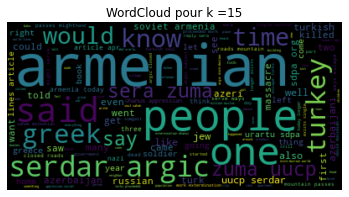

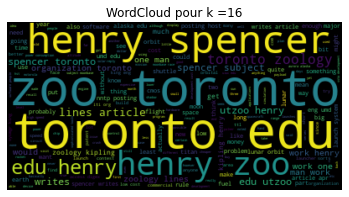

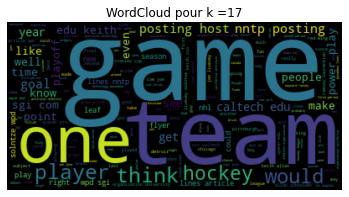

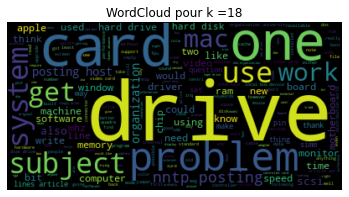

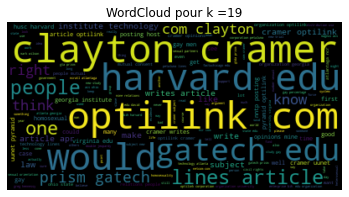

In [12]:
for i in range (20):
    plt.figure()
    plt.title("WordCloud pour k =%d" %i)
    wordcloud = WordCloud(stopwords=[]).generate(text_cluster[i])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")    

### Limites

- Limites liées à la description
    - trop de mots
    - trop de mots fréquents qui déroutent l'algorithme
    - ...
- Limites liées à l'algorithme
    - distance euclidienne absurde

Les limites algorithmiques vont être résolues en changeant d'algorithme... Les limites de représentation des données seront résolues par votre capacité en ingénierie.


Algorithmes à tester:
- LSA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

**Note:** pour des tests rapides, il est plus simple de rester dans le cadre de scikit-learn... Néanmoins, dans un milieu industriel, il faudrait exploiter des outils plus efficaces comme ceux présents dans la librairie ```gensim```. Si vous vous sentez à l'aise avec la donnée textuelles, allez directement vers ces outils:
https://radimrehurek.com/gensim/models/ldamodel.html

In [13]:
#LSA
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, n_iter=10, random_state=0)
reduc_svd = svd.fit_transform(vectors)

In [14]:
#LDA
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=20, max_iter=10, random_state=0)
reduc_lda = lda.fit_transform(vectors)

## Evaluation des performances

Les performances sont très dures à évaluer en clustering... Ce qui explique que cette évaluation est souvent, au moins partiellement, qualitative (=étudiée à l'oeil, sur des exemples ou des paramètres). 
Afin d'éviter de faire n'importe quoi, il faut aussi réfléchir à des métriques quantitatives.

### Qualitatif

Analyser le vocabulaire des différents clusters
1. En terme de mots les plus fréquents, les plus probables ou de dimensions des vecteurs propres les plus fortes.
1. En terme de mots discriminants
    - construction de critère de contraste (type odd's ratio) entre la présence dans une classe et présence dans les autres classe
1. Affichage 
    - des 10 ou 20 mots critiques de chaque classe ```print```
    - sous la forme de word cloud
    - affichage interactif avancé: http://www.kennyshirley.com/LDAvis/
        - pour une version intégrable dans un notebook: https://github.com/bmabey/pyLDAvis
        - merci de l'utiliser **après avoir compris le principe de réduction de la dimensionalité pour les clusters**
    
### Quantitatif

Pour donner des chiffres, il faut des étiquettes. C'est rarement le cas sur des jeux de données industriels... Mais c'est bon dans un cadre académique comme 20 newsgroups!

**Problème:** Comme nos algorithmes sont non supervisés, les sorties (bien que catégorielles) ne sont pas alignées avec l'encodage des étiquettes du jeu de données. Il faut trouver des astuces.

1. Etude basique sur la taille des clusters
    - est ce qu'une classe n'a pas tout attrapé?
1. Pureté = extraction de la classe majoritaire dans un cluster + calcul de la pureté du cluster
    - 1 score par cluster par défaut
    - agrégation par somme pondérée sur la taille des clusters
1. Indice de Rand  https://fr.wikipedia.org/wiki/Indice_de_Rand
1. Métrique adaptée à une hypothèse spécifique


**LSA**

In [15]:
labels = np.argmax(reduc_svd, axis=1)

label = {k:[] for k in range (20)}
for k in range (len(labels)):
    label[labels[k]].append(k)
       
text_cluster = {k:"" for k in range (20)}
for k in range (20):
    text_cluster[k] = ' '.join([newsgroups_train_clean[i] for i in label[k]])

**Mots les plus fréquents**

In [16]:
from collections import Counter
mots_freq = {}

for k,text in text_cluster.items():
    mots_freq[k]=Counter(text.split()).most_common(10)
    
mots_freq

{0: [('edu', 17516),
  ('com', 9983),
  ('subject', 9901),
  ('lines', 9581),
  ('organization', 9133),
  ('would', 7203),
  ('one', 7188),
  ('writes', 6270),
  ('article', 5899),
  ('like', 4902)],
 1: [('god', 1664),
  ('jesus', 731),
  ('one', 514),
  ('people', 446),
  ('believe', 401),
  ('would', 395),
  ('bible', 343),
  ('edu', 342),
  ('christ', 278),
  ('say', 277)],
 2: [('key', 1068),
  ('encryption', 650),
  ('chip', 578),
  ('clipper', 550),
  ('com', 434),
  ('keys', 372),
  ('government', 321),
  ('would', 321),
  ('one', 319),
  ('escrow', 318)],
 3: [('dos', 271),
  ('windows', 211),
  ('disk', 185),
  ('drive', 168),
  ('card', 135),
  ('hard', 118),
  ('controller', 116),
  ('scsi', 113),
  ('bit', 110),
  ('system', 104)],
 4: [('edu', 352),
  ('pitt', 287),
  ('gordon', 253),
  ('banks', 247),
  ('geb', 244),
  ('article', 125),
  ('writes', 104),
  ('subject', 101),
  ('organization', 101),
  ('lines', 100)],
 5: [('com', 329),
  ('subject', 82),
  ('lines', 80)

**WordCloud**

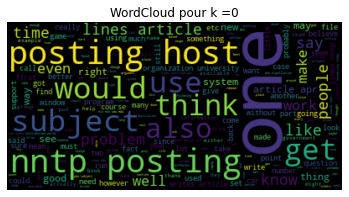

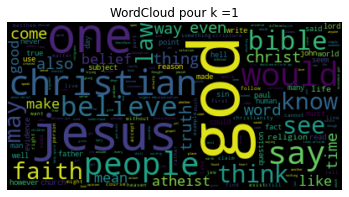

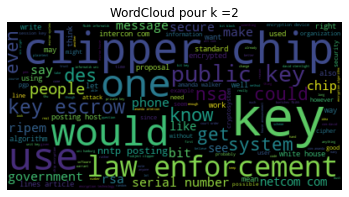

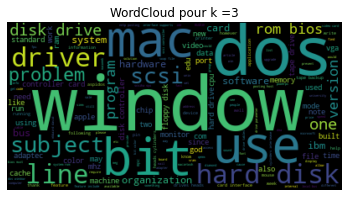

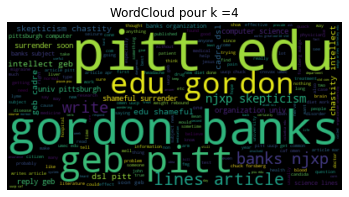

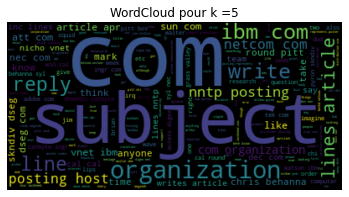

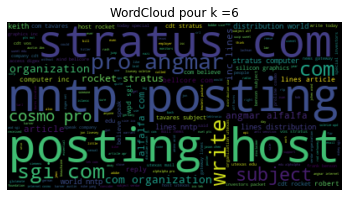

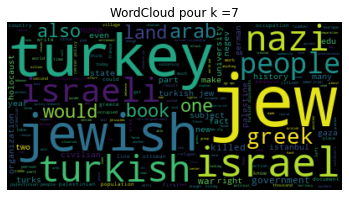

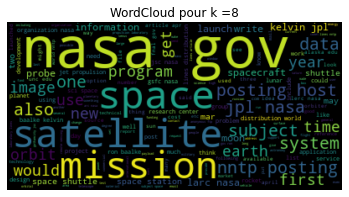

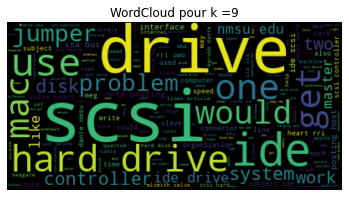

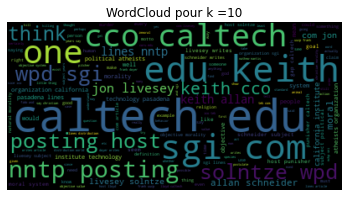

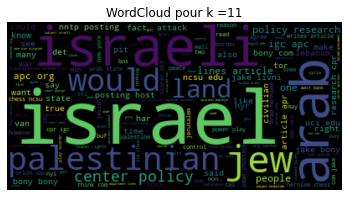

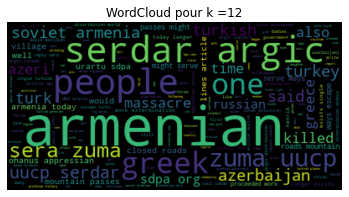

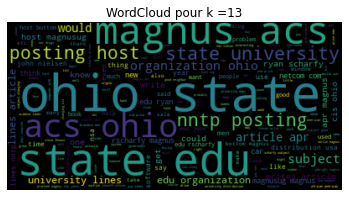

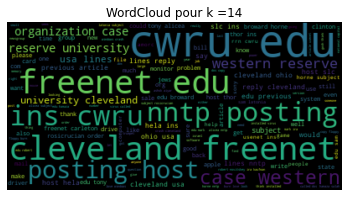

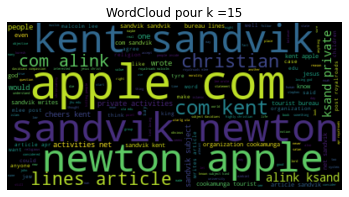

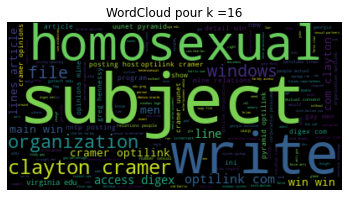

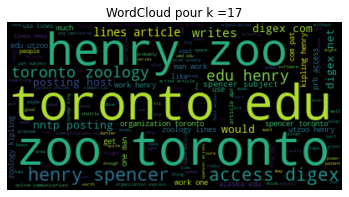

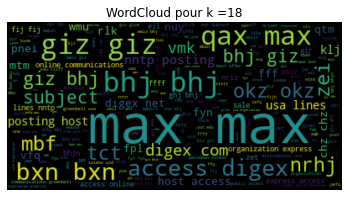

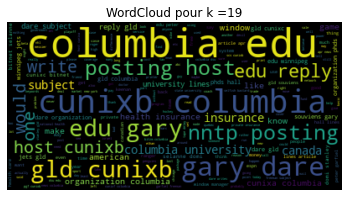

In [17]:
for i in range(20):
    plt.figure()
    plt.title("WordCloud pour k =%d" %i)
    wordcloud = WordCloud(stopwords=[]).generate(text_cluster[i])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")    

**LDA**

In [18]:
labels = np.argmax(reduc_lda, axis=1)

label = {k:[] for k in range (20)}
for k in range (len(labels)):
    label[labels[k]].append(k)
       
text_cluster = {k:"" for k in range (20)}
for k in range (20):
    text_cluster[k] = ' '.join([newsgroups_train_clean[i] for i in label[k]])

**Mots les plus fréquents**

In [19]:
from collections import Counter
mots_freq = {}

for k,text in text_cluster.items():
    mots_freq[k]=Counter(text.split()).most_common(10)
    
mots_freq

{0: [('com', 172),
  ('edu', 134),
  ('lib', 76),
  ('libxmu', 49),
  ('subject', 46),
  ('xmu', 46),
  ('lines', 44),
  ('organization', 43),
  ('echo', 38),
  ('cosmo', 32)],
 1: [('scx', 208),
  ('chz', 108),
  ('uww', 77),
  ('gcx', 66),
  ('rlk', 53),
  ('lhz', 51),
  ('rck', 48),
  ('mcx', 43),
  ('syx', 42),
  ('sqs', 42)],
 2: [('edu', 4704),
  ('one', 2755),
  ('people', 2739),
  ('god', 2604),
  ('subject', 2564),
  ('would', 2521),
  ('com', 2418),
  ('lines', 2381),
  ('organization', 2200),
  ('writes', 2150)],
 3: [('subject', 29),
  ('lines', 28),
  ('organization', 25),
  ('edu', 18),
  ('window', 13),
  ('ihr', 12),
  ('book', 11),
  ('article', 10),
  ('xsizehints', 10),
  ('schmidt', 10)],
 4: [('max', 4280),
  ('giz', 416),
  ('bhj', 366),
  ('bxn', 236),
  ('qax', 174),
  ('okz', 119),
  ('nrhj', 106),
  ('biz', 87),
  ('chz', 84),
  ('fyn', 81)],
 5: [('mov', 137),
  ('byte', 61),
  ('maxbyte', 42),
  ('edu', 38),
  ('bits', 37),
  ('subject', 34),
  ('lines', 34)

**WordCloud**

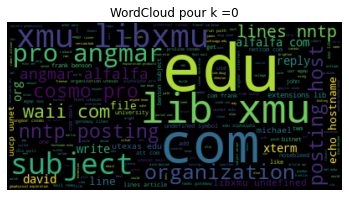

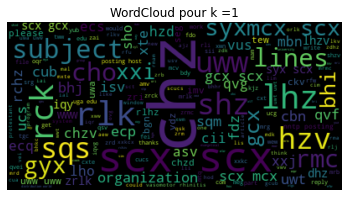

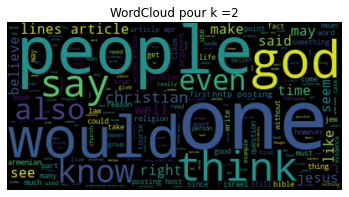

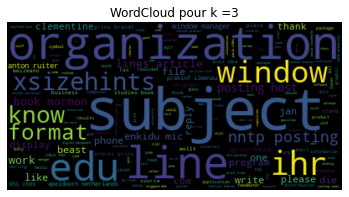

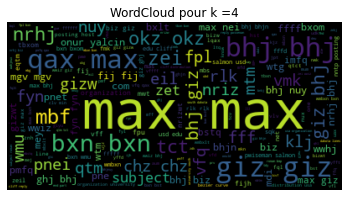

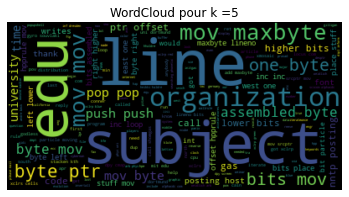

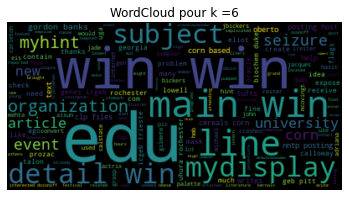

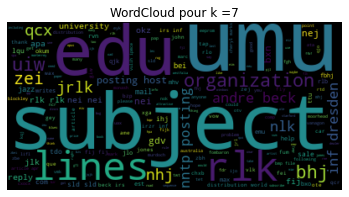

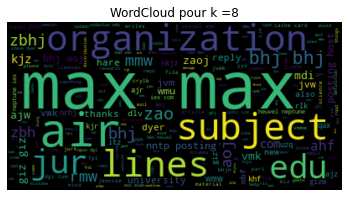

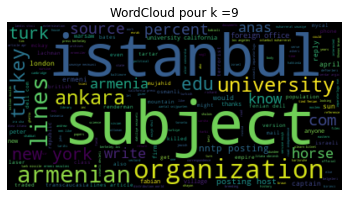

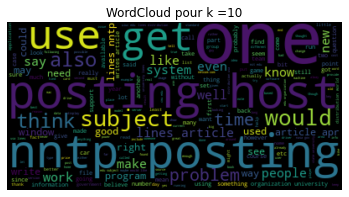

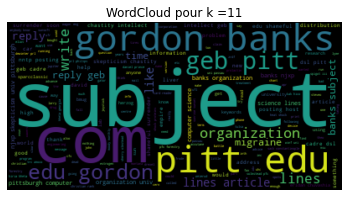

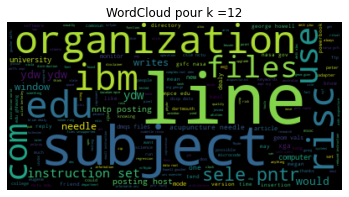

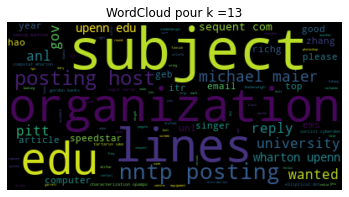

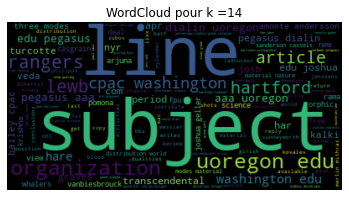

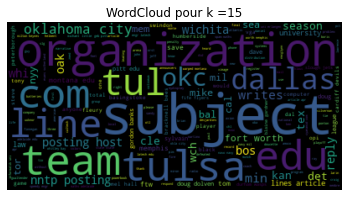

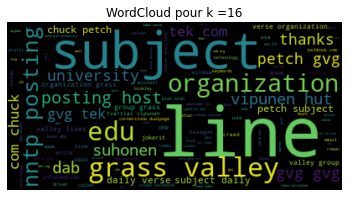

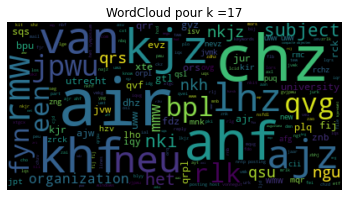

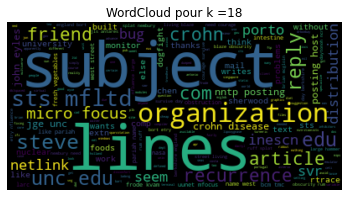

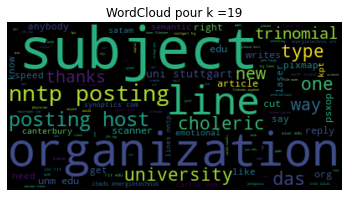

In [20]:
for i in range(20):
    plt.figure()
    plt.title("WordCloud pour k =%d" %i)
    wordcloud = WordCloud(stopwords=[]).generate(text_cluster[i])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")    

## Vers une version plus évoluée des algorithmes

1. Si l'un des clusters attiré toutes les données: êtes-vous capable de supprimer ce cluster et de simplement répartir les échantillons dans les autres catégories?

1. Si vous avez une idée vague des thématiques que vous souhaitez voir isolées... 
    - trouver 10 mots dans chaque catégories
    - biaiser l'initialisation pour attirer ces classes

1. Si vous mettez un utilisateur dans la boucle
    - passer en mode supervisé multiclasse et exploiter les feedbacks de l'utilisateur pour forcer le passage d'un document dans la classe d'à coté 
        - Naive Bayes, SVM ou autre...
    - réfléchir à une approche active qui sélectionne les documents les plus intéressants à montrer à l'utilisateur pour lui demander un étiquetage.